## Preprocessament d'imatges

### https://www.kaggle.com/code/pranavmoothedath/ds-updated

In [1]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image



In [2]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    

In [3]:
def gauss_circle(img):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img,(224,224))
     #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    #img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX= 30) ,-4 ,128)
    
    return img


In [4]:
def save_image(img_preprocessed, save_path):
    # Asegurar que img_preprocessed está en el rango correcto [0, 255] y es de tipo uint8
    img_preprocessed_clipped = np.clip(img_preprocessed, 0, 255)
    img_preprocessed_uint8 = img_preprocessed_clipped.astype(np.uint8)

    # Guardar la imagen
    cv2.imwrite(save_path, cv2.cvtColor(img_preprocessed_uint8, cv2.COLOR_RGB2BGR))


In [9]:
def preprocess_and_save(image_path, save_path):
    # Cargar imagen original con TensorFlow/Keras
    img = load_img(image_path)  # Esto carga la imagen como un objeto PIL Image
    
    # Convertir de PIL Image a array de numpy
    img_array = img_to_array(img)
    
    # Aplicar la función gauss_circle para el procesamiento de imágenes
    # gauss_circle ya redimensiona la imagen a 256x256
    img_processed = gauss_circle(img_array)
    save_image(img_processed, save_path)
    #return img_processed
    
 

Text(0.5, 1.0, 'Preprocessed Image')

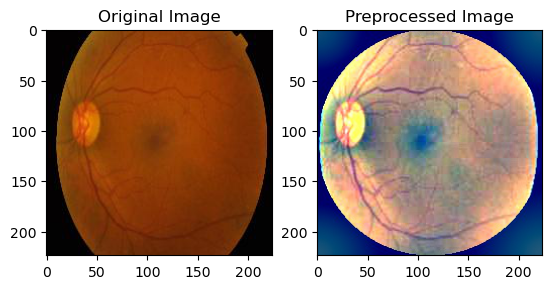

In [12]:
preprocess_and_save('original.jpg','preprocessed.jpg' )
# Crear una figura y ejes
fig, (ax1, ax2) = plt.subplots(1, 2)
original_img = load_img('original.jpg')
preprocessed_img= load_img('preprocessed.jpg')

# Mostrar la imagen original en ax1
ax1.imshow(original_img)
ax1.set_title('Original Image')

# Mostrar la imagen preprocesada en ax2
ax2.imshow(preprocessed_img)
ax2.set_title('Preprocessed Image')

In [9]:
new_image= preprocess_and_save(img_path, '10_left_processed.jpeg')


## Aplicar la funció preprocess_and_save per a generar un nou conjut de dades

In [16]:
import os
from pathlib import Path
from tqdm import tqdm

def preprocess_and_save_images_in_folder(source_folder, destination_folder):
    """
    Procesa y guarda las imágenes de todas las subcarpetas encontradas en source_folder,
    manteniendo la estructura de subcarpetas en destination_folder.
    """
    # Crear la carpeta de destino si no existe
    Path(destination_folder).mkdir(parents=True, exist_ok=True)
    
    # Buscar subcarpetas en la carpeta de origen
    subfolders = [f.path for f in os.scandir(source_folder) if f.is_dir()]
    
    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder)
        destination_subfolder = os.path.join(destination_folder, subfolder_name)
        
        # Crear subcarpeta de destino si no existe
        Path(destination_subfolder).mkdir(parents=True, exist_ok=True)
        
        # Procesar y guardar imágenes de la subcarpeta actual
        file_names = os.listdir(subfolder)
        for file_name in tqdm(file_names, desc=f"Processing {subfolder_name}"):
            source_path = os.path.join(subfolder, file_name)
            destination_path = os.path.join(destination_subfolder, file_name)
            
            # Aplicar la función de preprocesamiento y guardar la imagen
            preprocess_and_save(source_path, destination_path)

# Ejemplo de uso
source_folder = 'Dataset/test_original'
destination_folder = 'Dataset/test_preprocessed'
preprocess_and_save_images_in_folder(source_folder, destination_folder)



Processing No_DR: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 56.61it/s]


## Generar els tres conjunts de dades

In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define los porcentajes para la división de los datos
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Verifica que los porcentajes sumen 1 (o 100%)
#assert train_size + val_size + test_size == 1

# Función para dividir los datos y copiar los archivos
def split_data(source_dir, train_dir, val_dir, test_dir):
    # Crea las carpetas para los conjuntos de datos si no existen
    for folder in [train_dir, val_dir, test_dir]:
        os.makedirs(folder, exist_ok=True)
        # Crear carpetas para las clases específicas "DR" y "No_DR"
        os.makedirs(os.path.join(folder, "DR"), exist_ok=True)
        os.makedirs(os.path.join(folder, "No_DR"), exist_ok=True)

    # Iterar sobre cada subcarpeta de clase y dividir los archivos
    for class_name in ["DR", "No_DR"]:  # Especificar directamente las clases
        class_dir = os.path.join(source_dir, class_name)
        images = os.listdir(class_dir)

        # Usamos train_test_split dos veces para dividir en train, val y test
        train_images, temp_images = train_test_split(images, train_size=train_size, random_state=42)
        val_images, test_images = train_test_split(temp_images, train_size=val_size / (val_size + test_size), random_state=42)

        # Función auxiliar para copiar los archivos
        def copy_files(files, destination):
            for f in files:
                shutil.copy(os.path.join(class_dir, f), os.path.join(destination, class_name, f))

        # Copiar los archivos a las respectivas carpetas
        copy_files(train_images, train_dir)
        copy_files(val_images, val_dir)
        copy_files(test_images, test_dir)

# Llamada a la función split_data con las rutas apropiadas
preprocessed_dataset_dir = 'Preprocessed_Dataset'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

split_data(preprocessed_dataset_dir, train_dir, val_dir, test_dir)



## Augmentació de dades en les carpetes de les classes menys representades

In [4]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm

def augment_folder_images(source_folder, dest_folder, num_augmented_images, prefix):
    # Crea el ImageDataGenerator con las transformaciones deseadas
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Lista todas las imágenes en la carpeta de origen
    image_files = os.listdir(source_folder)

    # Crea la carpeta de destino si no existe
    os.makedirs(dest_folder, exist_ok=True)

    # Itera sobre todas las imágenes en la carpeta de origen
    for image_name in tqdm(image_files, desc='Aumentando imágenes'):
        # Carga la imagen y la convierte en un array
        image_path = os.path.join(source_folder, image_name)
        image = load_img(image_path)
        image_array = img_to_array(image)
        image_array = image_array.reshape((1,) + image_array.shape)

        # Copiar la imagen original al directorio de destino
        shutil.copy(image_path, dest_folder)

        # Preparar el nombre del archivo sin la extensión
        file_name, file_extension = os.path.splitext(image_name)
        
        # Crear las imágenes aumentadas
        i = 0
        for batch in datagen.flow(image_array, batch_size=1,
                                  save_to_dir=dest_folder,
                                  save_prefix=prefix + file_name,
                                  save_format='jpeg'):
            i += 1
            if i >= num_augmented_images:
                break  # Detener el bucle después de generar el número deseado de imágenes aumentadas

# Uso de la función
source_folder = 'train/DR'  # Por ejemplo, la clase '0'
dest_folder = 'train_augmented/DR'  # Destino donde guardar las imágenes aumentadas
num_augmented_images = 1  # Número deseado de imágenes aumentadas por cada imagen original
prefix = 'aug'  # Prefijo para las imágenes aumentadas

augment_folder_images(source_folder, dest_folder, num_augmented_images, prefix)


Aumentando imágenes: 100%|█████████████████████████████████████████████████████████| 6514/6514 [02:23<00:00, 45.46it/s]


## Fer subsampling

In [11]:
import os
import shutil
import random

# Fija la semilla del generador de números aleatorios para reproducibilidad
random.seed(42)

def move_random_files(source_folder, destination_folder, n):
    """
    Mueve N archivos seleccionados aleatoriamente de source_folder a destination_folder.

    :param source_folder: Carpeta de origen de los archivos.
    :param destination_folder: Carpeta de destino de los archivos.
    :param n: Número de archivos a mover.
    """
    # Lista todos los archivos en la carpeta de origen
    files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
    
    # Selecciona aleatoriamente N archivos
    selected_files = random.sample(files, min(n, len(files)))
    
    # Mueve cada archivo seleccionado a la carpeta de destino
    for file in selected_files:
        shutil.move(os.path.join(source_folder, file), os.path.join(destination_folder, file))
        print(f"Archivo {file} movido a {destination_folder}")

# Parámetros de ejemplo, reemplázalos por tus rutas reales
source_folder = 'Preprocessed_Dataset/No_DR'
destination_folder = 'Preprocessed_Dataset/No_DR_subsampled'
n = 9306  # Número de archivos a mover

# Llama a la función
move_random_files(source_folder, destination_folder, n)


Archivo 42343_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15674_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11298_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7668_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24059_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22511_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2134_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17133_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7404_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15230_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 44225_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7616_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37666_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14446_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archi

Archivo 34704_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13595_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 8619_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3710_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 8877_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16446_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16579_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43387_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3415_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37931_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1835_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23517_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 36844_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4071_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo

Archivo 15886_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15447_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7701_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9736_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17921_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23931_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2437_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40634_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20727_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 645_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 27324_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20324_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4861_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42095_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archiv

Archivo 16221_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33265_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16808_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33669_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43790_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37033_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38385_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40157_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26109_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9649_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32535_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4098_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6532_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 35658_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled

Archivo 24262_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40200_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5623_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24119_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38241_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1051_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 36286_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19688_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14388_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22314_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6568_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9536_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34841_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38208_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arch

Archivo 2669_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30850_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5192_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 35166_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24726_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43550_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30236_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37939_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11935_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33180_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14526_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25989_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22870_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26388_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Ar

Archivo 22092_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29328_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39000_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 28173_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39133_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25069_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5523_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2503_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11132_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43334_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9390_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24025_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1040_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7929_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo

Archivo 25345_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33335_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42553_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11612_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13173_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34356_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30329_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31685_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4800_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15507_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34928_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6207_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32585_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13802_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Ar

Archivo 25932_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39184_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3185_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39070_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30502_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6066_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42382_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3116_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24785_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15873_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30539_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11091_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26458_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18689_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arc

Archivo 43526_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29829_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16607_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 8280_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6025_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14353_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25762_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 8906_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29075_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4255_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26618_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16543_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 8209_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5713_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archi

Archivo 33317_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11946_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24968_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20216_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12307_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20116_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12206_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26027_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2578_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 36215_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30135_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37573_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34041_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22920_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled

Archivo 35560_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9717_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1853_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39967_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39420_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17860_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18648_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43354_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 41627_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40643_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 27049_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38597_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12157_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11448_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arch

Archivo 5869_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17065_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 36388_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20535_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9268_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26466_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43529_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34319_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 36713_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29082_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25952_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18734_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33409_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37137_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arc

Archivo 7238_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 36455_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9277_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15937_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9728_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20428_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 8061_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34864_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14653_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 35922_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32721_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12934_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33112_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1674_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arch

Archivo 15023_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9051_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26261_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20309_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 28780_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25929_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30967_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12428_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38554_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 21247_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17442_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 10833_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5692_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3812_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Ar

Archivo 4452_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39679_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43448_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29264_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14392_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 41294_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25041_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2258_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7518_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14204_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2368_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17860_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29262_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42083_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Ar

Archivo 18120_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26749_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38426_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31687_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33535_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2181_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7192_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 41884_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19329_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19448_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42403_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43289_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31992_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30018_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled


Archivo 24464_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2705_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37761_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7395_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1667_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38723_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34680_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 27365_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12586_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12433_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15062_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 41712_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7887_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 10835_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arch

Archivo 16512_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23725_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16047_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11512_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26938_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31862_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23907_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 36632_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13312_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23392_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39220_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 41778_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1395_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 35206_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
A

Archivo 33478_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1267_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18509_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43781_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32037_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29993_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43797_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11520_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 44027_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31700_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18722_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 27920_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2095_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19477_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Ar

Archivo 15325_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7084_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 27273_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18597_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29010_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18173_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43520_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37756_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 44163_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 27072_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40085_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 41041_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3453_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11605_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
A

Archivo 20178_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5305_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22744_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11741_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33262_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6144_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 28225_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20101_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6015_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33649_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3567_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30090_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42143_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arc

Archivo 2933_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 36968_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5473_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30923_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12851_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17716_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17028_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20162_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 27308_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30714_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38878_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4475_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17308_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26069_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled


Archivo 4548_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1914_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4462_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29235_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2814_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40924_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1147_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16683_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34559_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34819_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15755_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30830_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32440_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43773_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archi

Archivo 38522_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 44023_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 384_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29702_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22115_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 35954_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5856_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12478_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29335_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29648_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6263_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25907_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38052_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12842_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archiv

Archivo 41214_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42419_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19858_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15848_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19155_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38777_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12867_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37851_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33482_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43149_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13776_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24836_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1349_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22808_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampl

Archivo 21152_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6376_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40437_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1727_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39518_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19172_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 44254_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9900_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18496_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42574_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33112_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40220_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39899_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13579_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled

Archivo 6811_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5490_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34232_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25956_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 27901_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 44240_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3907_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42796_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19221_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19624_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 35376_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43131_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 21960_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22365_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archi

Archivo 4550_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33773_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4953_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23933_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37836_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32675_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16899_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4450_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9213_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39908_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40279_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3326_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 8683_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43654_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archiv

Archivo 24073_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 40336_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38178_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18136_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13579_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 8907_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17888_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32924_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9069_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4092_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37519_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 28592_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33138_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 10031_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled


Archivo 16189_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 21546_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5679_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43425_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1285_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25507_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 36658_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 627_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6210_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37448_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38671_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17649_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26540_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43418_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archi

Archivo 38758_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 21753_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7894_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39705_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9159_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5203_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14074_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34233_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5296_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 35541_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33843_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 678_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1929_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29647_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34

Archivo 8482_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20665_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20612_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13052_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15574_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38974_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9325_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14475_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34599_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24658_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31713_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43943_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23216_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4186_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archi

Archivo 7586_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14752_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3381_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14979_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33227_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25806_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5655_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 42607_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 21813_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 21377_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17334_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23133_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 28382_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29840_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled

Archivo 14242_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16509_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3569_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13952_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24199_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22863_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16773_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24334_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24063_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2307_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 10732_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9714_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18815_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 43067_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arc

Archivo 15424_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32478_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23182_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4844_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11829_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13765_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13637_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6314_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32742_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7210_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3530_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17606_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 10042_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11989_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arch

Archivo 21601_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15002_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22086_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30903_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20145_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29011_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 21208_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 6104_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33935_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 34633_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39060_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32160_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17382_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 21015_left.jpeg movido a Preprocessed_Dataset/No_DR_subsample

Archivo 6595_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18850_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 17819_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 41325_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 22131_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 1596_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12157_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26073_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16487_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32445_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23252_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 28713_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 19331_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2041_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arc

Archivo 17259_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 21534_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25651_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16417_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39207_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16650_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14026_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31586_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 15698_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13984_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 10962_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 3462_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38621_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12232_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arc

Archivo 23519_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12521_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25134_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38474_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37516_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5508_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 14842_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 27025_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23975_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5437_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5817_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 5514_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31715_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 20659_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Arc

Archivo 23252_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39481_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 38708_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 12327_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 41312_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9794_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24334_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2823_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31894_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 24420_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 41561_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 23425_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7727_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25931_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
A

Archivo 9279_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25993_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30329_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 18323_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32073_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 39022_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 29911_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11952_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 7093_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 13029_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25060_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 31252_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30352_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 25477_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled

Archivo 24022_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 9066_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 11192_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 2288_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33132_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 10100_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 4116_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 35880_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 26376_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 32005_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 30619_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 37064_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 16245_left.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archivo 33742_right.jpeg movido a Preprocessed_Dataset/No_DR_subsampled
Archi